In [1]:
!pip install fastf1 matplotlib pandas scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.4/148.4 kB 866.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.2 requires websockets>=14.0, but you have websockets 13.1 which is incompatible.


In [2]:
import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


In [3]:
import os

# Create cache directory if it doesn't exist
os.makedirs('./cache', exist_ok=True)


# Enable FastF1 cache (downloads and stores race data)
fastf1.Cache.enable_cache('./cache')

# Enable FastF1 cache
fastf1.Cache.enable_cache('./cache')

In [4]:
TEAM_COLORS = {
    'Red Bull Racing': '#1E41FF',
    'Mercedes': '#00D2BE',
    'Ferrari': '#DC0000',
    'McLaren': '#FF8700',
    'Aston Martin': '#006F62',
    'Alpine': '#0090FF',
    'Williams': '#005AFF',
    'AlphaTauri': '#2B4562',
    'Alfa Romeo': '#900000',
    'Haas F1 Team': '#B6BABD',
    'AlphaTauri RB': '#6692FF',
    'Stake F1 Team': '#52E252',
    'Kick Sauber': '#03B44C'
}

In [5]:
# Load session: 2025 British Grand Prix, Qualifying
session = fastf1.get_session(2025, 'Australian', 'Q')
session.load()

core           INFO 	Loading data for Australian Grand Prix - Qualifying [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Qualifying [v3.6.0]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '' in Ergastresponse.
req            INFO 	No cached data found for session_status_

In [6]:
# Get driver info with team
driver_info_df = session.results[['DriverNumber', 'Abbreviation', 'FullName', 'TeamName']].drop_duplicates()

# Rename columns
driver_info_df.columns = ['Number', 'Code', 'Name', 'Team']

# Display nicely
driver_info_df.sort_values(by='Number').reset_index(drop=True)

,Number,Code,Name,Team
0,1,VER,Max Verstappen,Red Bull Racing
1,10,GAS,Pierre Gasly,Alpine
2,12,ANT,Andrea Kimi Antonelli,Mercedes
3,14,ALO,Fernando Alonso,Aston Martin
4,16,LEC,Charles Leclerc,Ferrari
5,18,STR,Lance Stroll,Aston Martin
6,22,TSU,Yuki Tsunoda,Racing Bulls
7,23,ALB,Alexander Albon,Williams
8,27,HUL,Nico Hulkenberg,Kick Sauber
9,30,LAW,Liam Lawson,Red Bull Racing


In [7]:
# 🏎️ SWITCH DRIVERS HERE
driver1_number = '16'  # e.g., Hamilton
driver2_number = '81'  # e.g., Leclerc

laps1 = session.laps.pick_drivers(driver1_number).pick_quicklaps()
laps2 = session.laps.pick_drivers(driver2_number).pick_quicklaps()

lap1 = laps1.pick_fastest()
lap2 = laps2.pick_fastest()

# Get team colors
team_color1 = TEAM_COLORS.get(lap1['Team'], 'red')
team_color2 = TEAM_COLORS.get(lap2['Team'], 'blue')

tel1 = lap1.get_car_data().add_distance()
tel2 = lap2.get_car_data().add_distance()

# Get actual driver names
try:
    driver_info = session.results[['DriverNumber', 'FullName']].drop_duplicates()
    driver1_name = driver_info[driver_info['DriverNumber'] == int(driver1_number)]['FullName'].values[0]
    driver2_name = driver_info[driver_info['DriverNumber'] == int(driver2_number)]['FullName'].values[0]
except IndexError:
    driver1_name = lap1['Driver']
    driver2_name = lap2['Driver']

print(f"{driver1_name} (#{driver1_number}) - Fastest Lap: {lap1['LapNumber']}, Time: {lap1['LapTime']}")
print(f"{driver2_name} (#{driver2_number}) - Fastest Lap: {lap2['LapNumber']}, Time: {lap2['LapTime']}")

LEC (#16) - Fastest Lap: 17.0, Time: 0 days 00:01:15.755000
PIA (#81) - Fastest Lap: 17.0, Time: 0 days 00:01:15.180000


In [8]:
laps1[['LapNumber', 'LapTime']].head(10)
laps2[['LapNumber', 'LapTime']].head(10)

,LapNumber,LapTime
21,2.0,0 days 00:01:16.157000
24,5.0,0 days 00:01:16.062000
28,9.0,0 days 00:01:15.468000
33,14.0,0 days 00:01:16.147000
36,17.0,0 days 00:01:15.180000


In [9]:
lap_ver = laps1.pick_fastest()
lap_nor = laps2.pick_fastest()
# 📊 Extract telemetry
tel_ver = lap_ver.get_car_data().add_distance()
tel_nor = lap_nor.get_car_data().add_distance()

In [10]:
from scipy.interpolate import interp1d
# Interpolation functions to align Norris data to Verstappen's distance
interp_nor_speed = interp1d(tel_nor['Distance'], tel_nor['Speed'], bounds_error=False, fill_value="extrapolate")
interp_nor_throttle = interp1d(tel_nor['Distance'], tel_nor['Throttle'], bounds_error=False, fill_value="extrapolate")
interp_nor_brake = interp1d(tel_nor['Distance'], tel_nor['Brake'], bounds_error=False, fill_value="extrapolate")

# Interpolate tel2 to tel1's distance
interp_speed2 = interp1d(tel2['Distance'], tel2['Speed'], bounds_error=False, fill_value="extrapolate")
interp_throttle2 = interp1d(tel2['Distance'], tel2['Throttle'], bounds_error=False, fill_value="extrapolate")
interp_brake2 = interp1d(tel2['Distance'], tel2['Brake'], bounds_error=False, fill_value="extrapolate")

speed2_interp = interp_speed2(tel1['Distance'])
throttle2_interp = interp_throttle2(tel1['Distance'])
brake2_interp = interp_brake2(tel1['Distance'])

# Turn zones (braking points)
braking_indices = np.where((tel1['Speed'].diff() < -30) & (tel1['Speed'].shift(-1) < tel1['Speed']))[0]
turns = tel1['Distance'].iloc[braking_indices].drop_duplicates().tolist()

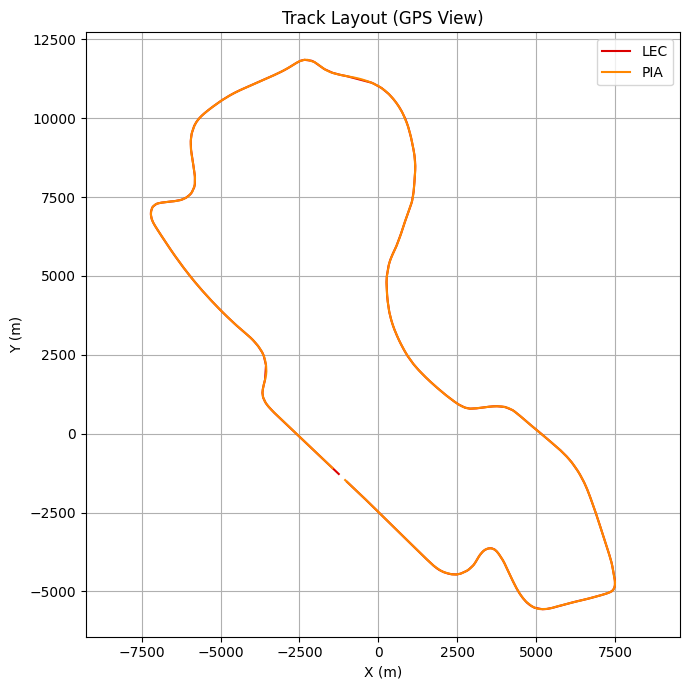

In [11]:
pos1 = lap1.get_pos_data().dropna()
pos2 = lap2.get_pos_data().dropna()

plt.figure(figsize=(7, 7))
plt.plot(pos1['X'], pos1['Y'], label=driver1_name, color=team_color1)
plt.plot(pos2['X'], pos2['Y'], label=driver2_name, color=team_color2)
plt.title("Track Layout (GPS View)")
plt.xlabel("X (m)"); plt.ylabel("Y (m)")
plt.axis('equal'); plt.grid(True); plt.legend()
plt.tight_layout()
plt.show()

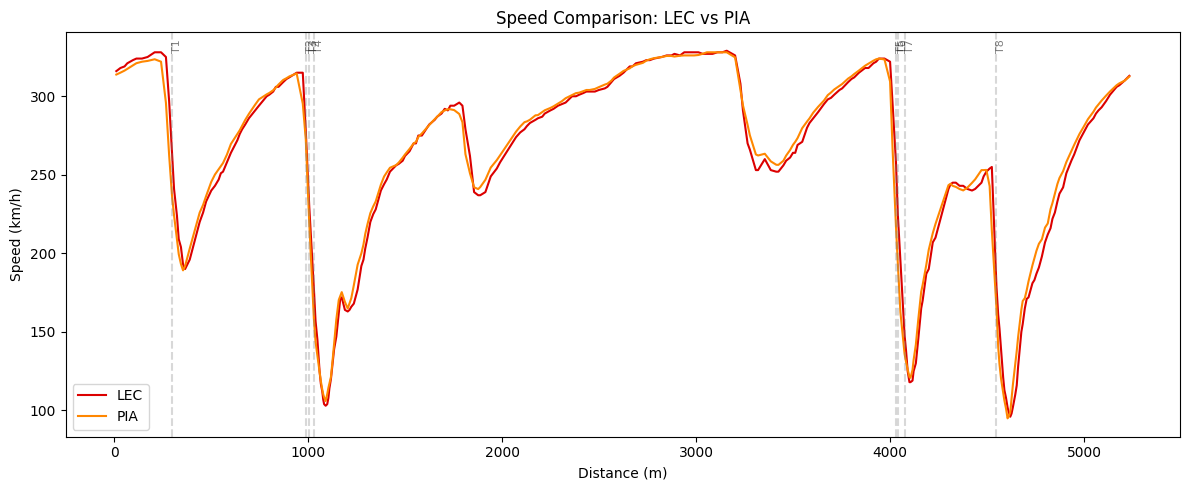

In [12]:
plt.figure(figsize=(12, 5))
plt.plot(tel1['Distance'], tel1['Speed'], label=driver1_name, color=team_color1)
plt.plot(tel1['Distance'], speed2_interp, label=driver2_name, color=team_color2)
plt.title(f"Speed Comparison: {driver1_name} vs {driver2_name}")
plt.xlabel("Distance (m)"); plt.ylabel("Speed (km/h)")

for i, d in enumerate(turns):
    plt.axvline(x=d, color='gray', linestyle='--', alpha=0.3)
    plt.text(d, max(tel1['Speed']), f'T{i+1}', rotation=90, fontsize=8, alpha=0.5)

plt.legend(); plt.tight_layout(); plt.show()

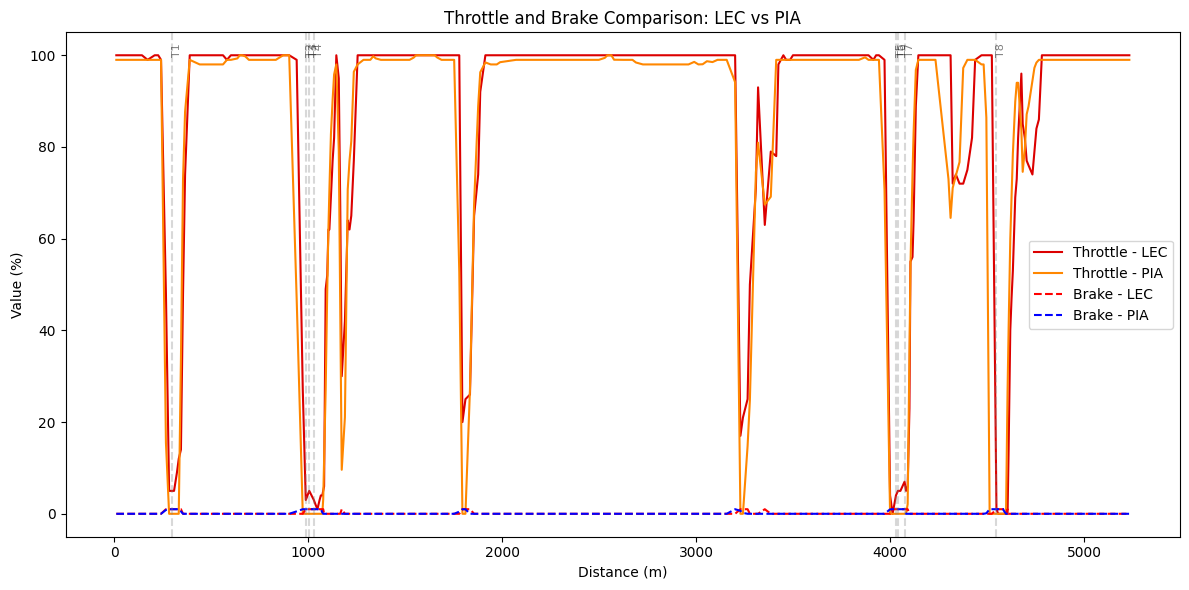

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(tel1['Distance'], tel1['Throttle'], label=f'Throttle - {driver1_name}', color=team_color1)
plt.plot(tel1['Distance'], throttle2_interp, label=f'Throttle - {driver2_name}', color=team_color2)
plt.plot(tel1['Distance'], tel1['Brake'], label=f'Brake - {driver1_name}', color='red', linestyle='dashed')
plt.plot(tel1['Distance'], brake2_interp, label=f'Brake - {driver2_name}', color='blue', linestyle='dashed')
plt.title(f"Throttle and Brake Comparison: {driver1_name} vs {driver2_name}")
plt.xlabel("Distance (m)"); plt.ylabel("Value (%)")

for i, d in enumerate(turns):
    plt.axvline(x=d, color='gray', linestyle='--', alpha=0.3)
    plt.text(d, 100, f'T{i+1}', rotation=90, fontsize=8, alpha=0.5)

plt.legend(); plt.tight_layout(); plt.show()

In [14]:
# Extract and combine telemetry for each lap
telemetry_data = []

for _, lap in laps1.iterrows():
    try:
        tel = lap.get_car_data().add_distance()
        tel['LapTime(s)'] = lap['LapTime'].total_seconds()
        telemetry_data.append(tel)
    except:
        pass  # skip laps with missing or incomplete data

# Combine all laps into one DataFrame
all_data = pd.concat(telemetry_data, ignore_index=True)
print("Telemetry data shape:", all_data.shape)
all_data.head(10)

Telemetry data shape: (1449, 12)


,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance,LapTime(s)
0,2025-03-15 05:04:03.152,11371.0,319.0,8,100.0,False,12,car,0 days 00:00:00.966000,0 days 00:16:31.553000,85.598333,76.453
1,2025-03-15 05:04:03.512,11430.0,320.0,8,100.0,False,12,car,0 days 00:00:01.326000,0 days 00:16:31.913000,117.598333,76.453
2,2025-03-15 05:04:03.672,11449.0,322.0,8,100.0,False,12,car,0 days 00:00:01.486000,0 days 00:16:32.073000,131.909444,76.453
3,2025-03-15 05:04:03.832,11453.0,322.0,8,100.0,False,12,car,0 days 00:00:01.646000,0 days 00:16:32.233000,146.220556,76.453
4,2025-03-15 05:04:04.272,11520.0,324.0,8,100.0,False,12,car,0 days 00:00:02.086000,0 days 00:16:32.673000,185.820556,76.453
5,2025-03-15 05:04:04.472,11547.0,326.0,8,100.0,False,12,car,0 days 00:00:02.286000,0 days 00:16:32.873000,203.931667,76.453
6,2025-03-15 05:04:04.632,11530.0,326.0,8,100.0,False,12,car,0 days 00:00:02.446000,0 days 00:16:33.033000,218.420556,76.453
7,2025-03-15 05:04:04.872,11514.0,324.0,8,99.0,False,10,car,0 days 00:00:02.686000,0 days 00:16:33.273000,240.020556,76.453
8,2025-03-15 05:04:05.032,11225.0,323.0,8,9.0,True,10,car,0 days 00:00:02.846000,0 days 00:16:33.433000,254.376111,76.453
9,2025-03-15 05:04:05.352,10344.0,272.0,8,1.0,True,8,car,0 days 00:00:03.166000,0 days 00:16:33.753000,278.553889,76.453


In [15]:
print(all_data.columns.tolist())

['Date', 'RPM', 'Speed', 'nGear', 'Throttle', 'Brake', 'DRS', 'Source', 'Time', 'SessionTime', 'Distance', 'LapTime(s)']


In [16]:
# Input features and prediction target
features = all_data[['Speed', 'Throttle', 'Brake', 'RPM', 'nGear']]
target = all_data['LapTime(s)']

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"🔮 Mean Absolute Error (MAE) for {driver1_name}: {mae:.2f} seconds")

🔮 Mean Absolute Error (MAE) for LEC: 0.21 seconds


In [17]:
# Create comparison table
comparison = pd.DataFrame({
    'Actual Lap Time (s)': y_test.reset_index(drop=True),
    'Predicted Lap Time (s)': y_pred
})

comparison.head(10)

,Actual Lap Time (s),Predicted Lap Time (s)
0,76.029,76.261640
1,75.838,75.867220
2,76.453,76.173630
3,75.755,76.040620
4,76.453,75.847725
5,75.838,76.180612
6,75.827,75.926570
7,75.838,75.970480
8,75.827,76.201360
9,75.755,75.859520


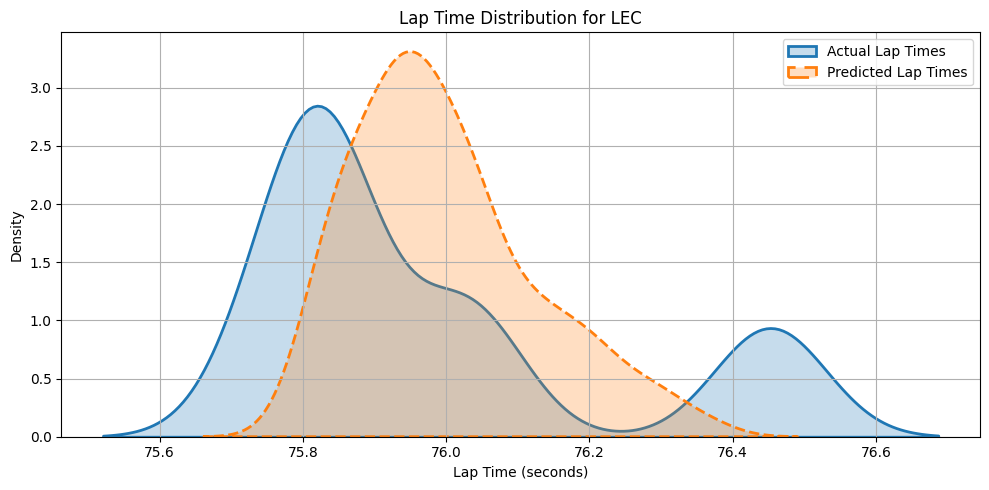

In [18]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, label='Actual Lap Times', fill=True, linewidth=2)
sns.kdeplot(y_pred, label='Predicted Lap Times', fill=True, linestyle='--', linewidth=2)
plt.title(f"Lap Time Distribution for {driver1_name}")
plt.xlabel("Lap Time (seconds)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

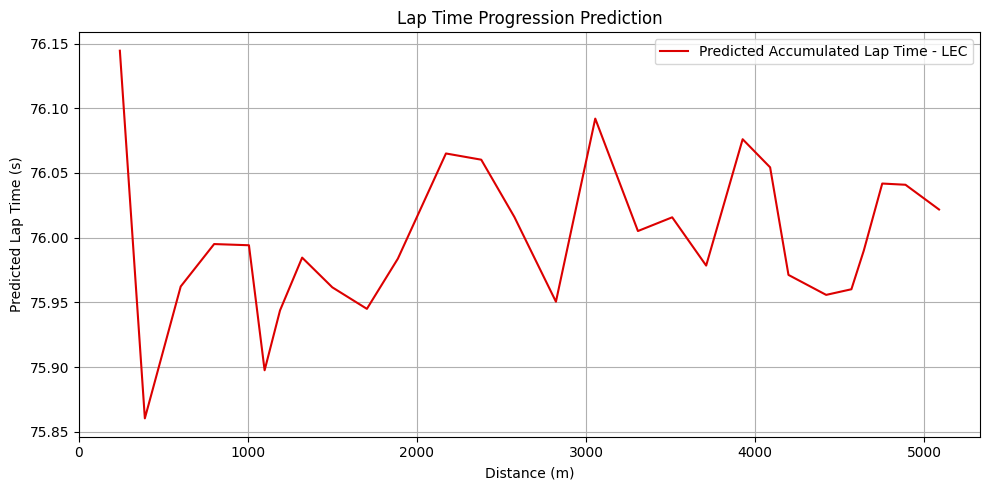

In [19]:
lap_features = tel1[['Speed', 'Throttle', 'Brake', 'RPM', 'nGear']].copy()
predicted_times = []

# Predict lap time at each point progressively (accumulative)
for i in range(10, len(lap_features), 10):  # every 10 data points
    partial = lap_features.iloc[:i]
    mean_feat = partial.mean().to_frame().T  # Average values till now
    pred = model.predict(mean_feat)[0]
    predicted_times.append((tel1['Distance'].iloc[i], pred))

distances = [x[0] for x in predicted_times]
times = [x[1] for x in predicted_times]

plt.figure(figsize=(10, 5))
plt.plot(distances, times, label=f'Predicted Accumulated Lap Time - {driver1_name}', color=team_color1)
plt.xlabel("Distance (m)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Lap Time Progression Prediction")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# Prepare dictionary of models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Linear Regression': LinearRegression(),
    'Support Vector Regressor': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

# Train each model and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'mae': mae
    }
    print(f"{name} MAE: {mae:.3f} seconds")

Random Forest MAE: 0.213 seconds
Linear Regression MAE: 0.197 seconds
Support Vector Regressor MAE: 0.187 seconds
Gradient Boosting MAE: 0.198 seconds


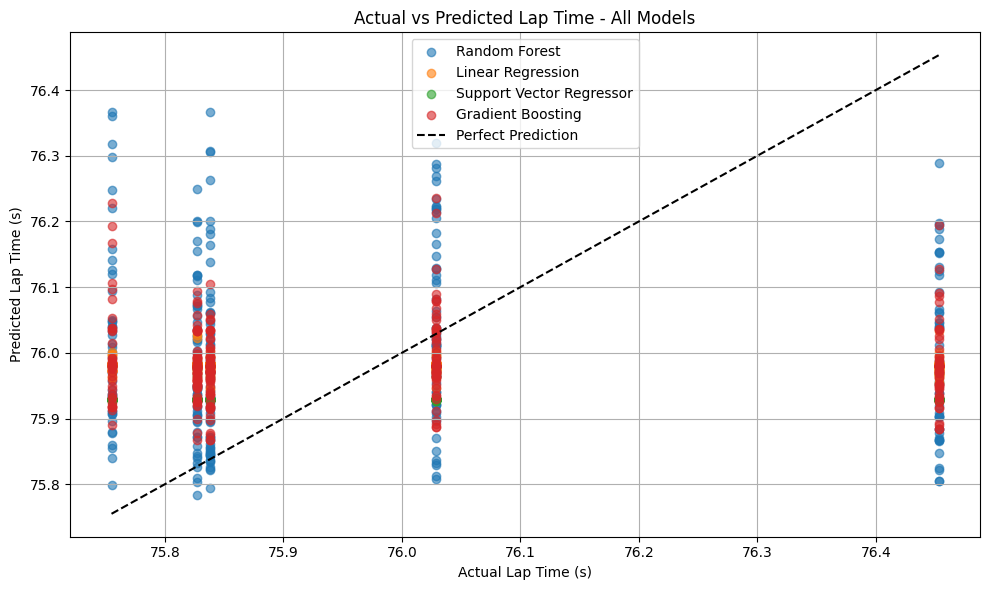

In [21]:
plt.figure(figsize=(10, 6))

for name, res in results.items():
    plt.scatter(y_test, res['y_pred'], label=name, alpha=0.6)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Perfect Prediction')
plt.xlabel("Actual Lap Time (s)")
plt.ylabel("Predicted Lap Time (s)")
plt.title("Actual vs Predicted Lap Time - All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

mae_df = pd.DataFrame({
    "Model": [name for name in results],
    "MAE (s)": [results[name]['mae'] for name in results]
}).sort_values(by="MAE (s)")

mae_df.reset_index(drop=True)

,Model,MAE (s)
0,Support Vector Regressor,0.186576
1,Linear Regression,0.197236
2,Gradient Boosting,0.198436
3,Random Forest,0.212877


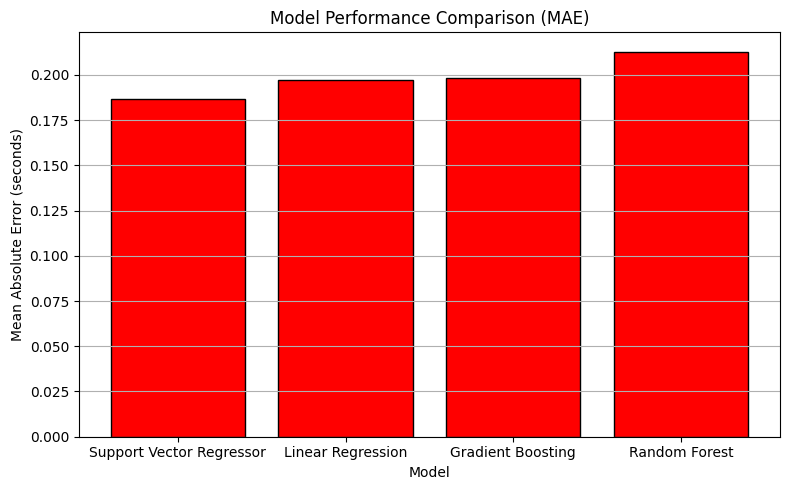

In [23]:
import matplotlib.pyplot as plt

# Bar chart for MAE comparison
plt.figure(figsize=(8, 5))
plt.bar(mae_df['Model'], mae_df['MAE (s)'], color='red', edgecolor='black')
plt.title("Model Performance Comparison (MAE)")
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error (seconds)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()